# 데이터셋 불러오기

In [1]:
# IMA이미지를 불러오는 라이브러리
import pydicom

import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [3.0, 3.0]
import seaborn as sns
import torch.nn as nn

In [2]:
import glob

L_list = glob.glob('/root/Mayo2016/*')
L_list = [path.split('/')[-1] for path in L_list]
L_list.sort()
L_list

['L067',
 'L096',
 'L109',
 'L143',
 'L192',
 'L286',
 'L291',
 'L310',
 'L333',
 'L506']

In [3]:
data_label = ['quarter_1mm', 'full_1mm']

In [4]:
def normlize(path):
  dicom_data = pydicom.dcmread(path)
  img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept
  mu, sd = (-500,500)
  scaled_img = (img - mu) / sd
  img = np.expand_dims(scaled_img, axis=0)

  return img # 1x512x512

In [5]:
def extract_patches(img, patch_size=55, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55

In [6]:
import random
from scipy.ndimage import rotate, zoom

def augment_patches(X_patches, y_patches, p=0.5):
    X_augmented_patches, y_augmented_patches = [], []
    
    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [7]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  return X_augmented_patches, y_augmented_patches

In [8]:
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  return X_patches, y_patches

In [9]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir
            y_dir_list += y_dir

        for X_dir, y_dir in tqdm(zip(X_dir_list, y_dir_list), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            for i in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[i]), torch.from_numpy(y_patches[i]) # torch로 넣어주자.
                self.image_pairs.append((X_patch, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)
        
        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = self.image_pairs[idx][0]
        y = self.image_pairs[idx][1]
        return X, y

In [10]:
# 파일 경로 설정

root = '/root/code/'
train_path = root+'train_dataset.pt'
val_path = root+'val_dataset.pt'
test_path = root+'test_dataset.pt'

In [11]:
# 4분 정도 소요

# 데이터셋 불러오기
train_dataset = torch.load(train_path)
val_dataset = torch.load(val_path)
test_dataset = torch.load(test_path) # 45초

In [12]:
batch_size = 16
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [13]:
len(train_loader), len(val_loader), len(test_loader)

(57696, 4815, 6025)

# 모델1 - base

In [24]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:
import torch
import torch.nn as nn

class RedCNN(nn.Module):
    def __init__(self):
        super(RedCNN, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)
        
        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()


    def forward(self, x):
        # 인코더 부분
        residual1 = x  # 첫 번째 잔차 저장
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x  # 두 번째 잔차 저장
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        residual3 = x  # 세 번째 잔차 저장
        x = self.relu(self.conv5(x))
        
        # 디코더 부분 (잔차를 더해줌)
        x = self.relu(self.deconv1(x)) + residual3  # 세 번째 잔차 연결
        x = self.relu(self.deconv2(x))
        x = self.relu((self.deconv3(x)) + residual2)  # 두 번째 잔차 연결
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1  # 첫 번째 잔차 연결
        
        return x


In [26]:
model = RedCNN().to(device)
model

RedCNN(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv_last): ConvTranspose2d(96, 1, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
)

In [27]:
%cd /root/code

import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

/root/code


<module 'utils.train_eval_util' from '/root/code/utils/train_eval_util.py'>

In [28]:
import torch.nn as nn
criterion = nn.MSELoss()

from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

In [29]:
import torch
from tqdm import tqdm

interval = 1000

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X)
        loss = criterion(X_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            loss = criterion(X_hat, y)

            running_loss += loss.item() * X.size(0)

            if i % interval == interval-1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                total_loss += running_loss
                running_loss = 0.0
                tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)

In [30]:
!pwd

/root/code


In [31]:
%cd /root/code/redcnn/exp

/root/code/redcnn/exp


In [32]:
epochs = 1 # 각 epoch마다 train(20분), valid(2분)이 소요된다.
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if (early_stopping(valid_loss)):
        break

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./" + 'None' + ".pth")

Epoch 0 - Training:   2%|▏         | 1006/57696 [00:19<18:42, 50.51it/s]

train loss : 0.07178331959247589


Epoch 0 - Training:   3%|▎         | 2008/57696 [00:39<18:19, 50.64it/s]

train loss : 0.055104286832734946


Epoch 0 - Training:   5%|▌         | 3010/57696 [00:59<18:00, 50.62it/s]

train loss : 0.05103286227211356


Epoch 0 - Training:   7%|▋         | 4006/57696 [01:18<17:41, 50.57it/s]

train loss : 0.048383812082931396


Epoch 0 - Training:   9%|▊         | 5008/57696 [01:38<17:23, 50.51it/s]

train loss : 0.046783961156383155


Epoch 0 - Training:  10%|█         | 6010/57696 [01:58<17:01, 50.58it/s]

train loss : 0.04568899576924741


Epoch 0 - Training:  12%|█▏        | 7006/57696 [02:17<16:43, 50.50it/s]

train loss : 0.044984801232814786


Epoch 0 - Training:  14%|█▍        | 8008/57696 [02:37<16:24, 50.44it/s]

train loss : 0.04400915402546525


Epoch 0 - Training:  16%|█▌        | 9010/57696 [02:57<16:01, 50.61it/s]

train loss : 0.04300463438034058


Epoch 0 - Training:  17%|█▋        | 10006/57696 [03:16<15:44, 50.51it/s]

train loss : 0.042463369712233544


Epoch 0 - Training:  19%|█▉        | 11008/57696 [03:36<15:23, 50.56it/s]

train loss : 0.04178040597774088


Epoch 0 - Training:  21%|██        | 12010/57696 [03:56<15:04, 50.51it/s]

train loss : 0.041486892186105254


Epoch 0 - Training:  23%|██▎       | 13006/57696 [04:15<14:46, 50.40it/s]

train loss : 0.04109294169023633


Epoch 0 - Training:  24%|██▍       | 14008/57696 [04:35<14:25, 50.47it/s]

train loss : 0.04102047740109265


Epoch 0 - Training:  26%|██▌       | 15010/57696 [04:55<14:03, 50.59it/s]

train loss : 0.040625842167064545


Epoch 0 - Training:  28%|██▊       | 16006/57696 [05:14<13:45, 50.51it/s]

train loss : 0.040036785915493964


Epoch 0 - Training:  29%|██▉       | 17008/57696 [05:34<13:25, 50.49it/s]

train loss : 0.0400663893353194


Epoch 0 - Training:  31%|███       | 18010/57696 [05:54<13:03, 50.64it/s]

train loss : 0.03963093840144575


Epoch 0 - Training:  33%|███▎      | 19006/57696 [06:13<12:41, 50.78it/s]

train loss : 0.03946270799078047


Epoch 0 - Training:  35%|███▍      | 20008/57696 [06:33<12:25, 50.58it/s]

train loss : 0.03951117846928537


Epoch 0 - Training:  36%|███▋      | 21010/57696 [06:53<12:05, 50.54it/s]

train loss : 0.038978689406067135


Epoch 0 - Training:  38%|███▊      | 22006/57696 [07:12<11:41, 50.88it/s]

train loss : 0.03908469231799245


Epoch 0 - Training:  40%|███▉      | 23008/57696 [07:32<11:26, 50.51it/s]

train loss : 0.03842692189849913


Epoch 0 - Training:  42%|████▏     | 24010/57696 [07:51<11:06, 50.52it/s]

train loss : 0.03846339240670204


Epoch 0 - Training:  43%|████▎     | 25006/57696 [08:11<10:46, 50.59it/s]

train loss : 0.03851138547621667


Epoch 0 - Training:  45%|████▌     | 26008/57696 [08:31<10:26, 50.59it/s]

train loss : 0.03794299328699708


Epoch 0 - Training:  47%|████▋     | 27010/57696 [08:50<10:06, 50.62it/s]

train loss : 0.03858606062270701


Epoch 0 - Training:  49%|████▊     | 28006/57696 [09:10<09:48, 50.44it/s]

train loss : 0.038395150676369665


Epoch 0 - Training:  50%|█████     | 29008/57696 [09:30<09:24, 50.80it/s]

train loss : 0.03778087846562266


Epoch 0 - Training:  52%|█████▏    | 30010/57696 [09:49<09:08, 50.49it/s]

train loss : 0.03756425898335874


Epoch 0 - Training:  54%|█████▎    | 31006/57696 [10:09<08:43, 50.94it/s]

train loss : 0.03780511333607137


Epoch 0 - Training:  55%|█████▌    | 32008/57696 [10:29<08:28, 50.48it/s]

train loss : 0.03796712533943355


Epoch 0 - Training:  57%|█████▋    | 33010/57696 [10:48<08:08, 50.52it/s]

train loss : 0.03750236022938043


Epoch 0 - Training:  59%|█████▉    | 34006/57696 [11:08<07:48, 50.52it/s]

train loss : 0.03766304586455226


Epoch 0 - Training:  61%|██████    | 35008/57696 [11:28<07:29, 50.49it/s]

train loss : 0.03768907548673451


Epoch 0 - Training:  62%|██████▏   | 36010/57696 [11:47<07:07, 50.75it/s]

train loss : 0.03757040610350668


Epoch 0 - Training:  64%|██████▍   | 37006/57696 [12:07<06:49, 50.57it/s]

train loss : 0.036993017522618174


Epoch 0 - Training:  66%|██████▌   | 38008/57696 [12:26<06:29, 50.57it/s]

train loss : 0.03749478789325804


Epoch 0 - Training:  68%|██████▊   | 39010/57696 [12:46<06:09, 50.57it/s]

train loss : 0.03694032029248774


Epoch 0 - Training:  69%|██████▉   | 40006/57696 [13:06<05:49, 50.56it/s]

train loss : 0.03696114254370332


Epoch 0 - Training:  71%|███████   | 41008/57696 [13:25<05:29, 50.60it/s]

train loss : 0.03650166327506304


Epoch 0 - Training:  73%|███████▎  | 42010/57696 [13:45<05:10, 50.55it/s]

train loss : 0.03663634305819869


Epoch 0 - Training:  75%|███████▍  | 43006/57696 [14:05<04:50, 50.52it/s]

train loss : 0.03659128013066947


Epoch 0 - Training:  76%|███████▋  | 44008/57696 [14:24<04:30, 50.57it/s]

train loss : 0.03667831198312342


Epoch 0 - Training:  78%|███████▊  | 45010/57696 [14:44<04:10, 50.66it/s]

train loss : 0.036885466542094944


Epoch 0 - Training:  80%|███████▉  | 46006/57696 [15:04<03:51, 50.56it/s]

train loss : 0.03691105475462973


Epoch 0 - Training:  81%|████████▏ | 47008/57696 [15:23<03:31, 50.65it/s]

train loss : 0.03712823657877743


Epoch 0 - Training:  83%|████████▎ | 48010/57696 [15:43<03:11, 50.63it/s]

train loss : 0.0368313090801239


Epoch 0 - Training:  85%|████████▍ | 49006/57696 [16:03<02:51, 50.69it/s]

train loss : 0.03649287746846676


Epoch 0 - Training:  87%|████████▋ | 50008/57696 [16:22<02:31, 50.70it/s]

train loss : 0.03642910240404308


Epoch 0 - Training:  88%|████████▊ | 51010/57696 [16:42<02:12, 50.62it/s]

train loss : 0.036432971165515485


Epoch 0 - Training:  90%|█████████ | 52006/57696 [17:01<01:52, 50.57it/s]

train loss : 0.03615936531126499


Epoch 0 - Training:  92%|█████████▏| 53008/57696 [17:21<01:32, 50.54it/s]

train loss : 0.03669936626777053


Epoch 0 - Training:  94%|█████████▎| 54010/57696 [17:41<01:12, 50.63it/s]

train loss : 0.03651138449460268


Epoch 0 - Training:  95%|█████████▌| 55006/57696 [18:00<00:53, 50.56it/s]

train loss : 0.036725042572245


Epoch 0 - Training:  97%|█████████▋| 56008/57696 [18:20<00:33, 50.59it/s]

train loss : 0.03655342063121498


Epoch 0 - Training:  99%|█████████▉| 57010/57696 [18:40<00:13, 50.67it/s]

train loss : 0.0360836580786854


Epoch 0 - Evaluating:  21%|██        | 1014/4815 [00:08<00:30, 123.92it/s]

train loss : 0.042047373901121315


Epoch 0 - Evaluating:  42%|████▏     | 2015/4815 [00:16<00:22, 123.97it/s]

train loss : 0.04553423090325669


Epoch 0 - Evaluating:  63%|██████▎   | 3016/4815 [00:24<00:14, 123.86it/s]

train loss : 0.02997229593503289


Epoch 0 - Evaluating:  83%|████████▎ | 4017/4815 [00:32<00:06, 123.85it/s]

train loss : 0.03345628417422995


Epoch 0 - Evaluating: 100%|██████████| 4815/4815 [00:38<00:00, 124.56it/s]

Epoch [1/1], Train Loss: 0.0025, Valid Loss: 0.0020


In [33]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load('None.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1009/6025 [00:22<01:50, 45.25it/s]

RMSE per interval: 0.0458, PSNR per interval: 27.62, SSIM per interval: 0.6728


Evaluating:  33%|███▎      | 2009/6025 [00:44<01:28, 45.39it/s]

RMSE per interval: 0.0434, PSNR per interval: 28.38, SSIM per interval: 0.6884


Evaluating:  50%|████▉     | 3009/6025 [01:05<01:06, 45.37it/s]

RMSE per interval: 0.0436, PSNR per interval: 28.54, SSIM per interval: 0.6978


Evaluating:  67%|██████▋   | 4009/6025 [01:27<00:44, 45.28it/s]

RMSE per interval: 0.0372, PSNR per interval: 29.54, SSIM per interval: 0.7249


Evaluating:  83%|████████▎ | 5009/6025 [01:49<00:22, 45.33it/s]

RMSE per interval: 0.0369, PSNR per interval: 29.63, SSIM per interval: 0.7034


Evaluating: 100%|█████████▉| 6009/6025 [02:11<00:00, 45.26it/s]

RMSE per interval: 0.0349, PSNR per interval: 30.34, SSIM per interval: 0.7449


Evaluating: 100%|██████████| 6025/6025 [02:12<00:00, 45.61it/s]

Average RMSE over all intervals: 0.040289


In [34]:
import os
import numpy as np

s = 'None' + '_'

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(s+file_names["loss"], loss_list)
np.save(s+file_names["psnr"], psnr_list)
np.save(s+file_names["ssim"], ssim_list)

print(f"Lists have been saved in the 'unet' folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")

Lists have been saved in the 'unet' folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


# 모델2 - weight init

In [35]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [36]:
import torch
import torch.nn as nn

class RedCNN(nn.Module):
    def __init__(self):
        super(RedCNN, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)
        
        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

        # Kaiming He 초기화 (ReLU에 적합)
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv4.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv5.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.deconv1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.deconv2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.deconv3.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.deconv4.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.deconv_last.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        # 인코더 부분
        residual1 = x  # 첫 번째 잔차 저장
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x  # 두 번째 잔차 저장
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        residual3 = x  # 세 번째 잔차 저장
        x = self.relu(self.conv5(x))
        
        # 디코더 부분 (잔차를 더해줌)
        x = self.relu(self.deconv1(x)) + residual3  # 세 번째 잔차 연결
        x = self.relu(self.deconv2(x))
        x = self.relu((self.deconv3(x)) + residual2)  # 두 번째 잔차 연결
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1  # 첫 번째 잔차 연결
        
        return x


In [37]:
model = RedCNN().to(device)
model

RedCNN(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv_last): ConvTranspose2d(96, 1, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
)

In [38]:
%cd /root/code

import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

/root/code


<module 'utils.train_eval_util' from '/root/code/utils/train_eval_util.py'>

In [39]:
import torch.nn as nn
criterion = nn.MSELoss()

from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

In [40]:
import torch
from tqdm import tqdm

interval = 1000

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X)
        loss = criterion(X_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            loss = criterion(X_hat, y)

            running_loss += loss.item() * X.size(0)

            if i % interval == interval-1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                total_loss += running_loss
                running_loss = 0.0
                tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)

In [41]:
!pwd

/root/code


In [42]:
%cd /root/code/redcnn/exp

/root/code/redcnn/exp


In [43]:
epochs = 1 # 각 epoch마다 train(20분), valid(2분)이 소요된다.
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if (early_stopping(valid_loss)):
        break

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./" + 'WI' + ".pth")

Epoch 0 - Training:   2%|▏         | 1007/57696 [00:19<18:37, 50.72it/s]

train loss : 0.0931582948230207


Epoch 0 - Training:   3%|▎         | 2009/57696 [00:39<18:20, 50.62it/s]

train loss : 0.06578957661055028


Epoch 0 - Training:   5%|▌         | 3005/57696 [00:59<18:01, 50.57it/s]

train loss : 0.05791139341704547


Epoch 0 - Training:   7%|▋         | 4007/57696 [01:18<17:40, 50.62it/s]

train loss : 0.055535171465948226


Epoch 0 - Training:   9%|▊         | 5009/57696 [01:38<17:19, 50.71it/s]

train loss : 0.05264441871456802


Epoch 0 - Training:  10%|█         | 6005/57696 [01:57<17:02, 50.55it/s]

train loss : 0.0517525153644383


Epoch 0 - Training:  12%|█▏        | 7007/57696 [02:17<16:41, 50.61it/s]

train loss : 0.04939675032347441


Epoch 0 - Training:  14%|█▍        | 8009/57696 [02:37<16:21, 50.63it/s]

train loss : 0.04795146902650595


Epoch 0 - Training:  16%|█▌        | 9005/57696 [02:56<16:00, 50.68it/s]

train loss : 0.04730496442504227


Epoch 0 - Training:  17%|█▋        | 10007/57696 [03:16<15:41, 50.64it/s]

train loss : 0.04688938131369651


Epoch 0 - Training:  19%|█▉        | 11009/57696 [03:36<15:21, 50.67it/s]

train loss : 0.045220120429992676


Epoch 0 - Training:  21%|██        | 12005/57696 [03:55<15:03, 50.60it/s]

train loss : 0.044329036232084035


Epoch 0 - Training:  23%|██▎       | 13007/57696 [04:15<14:41, 50.72it/s]

train loss : 0.04436461994051933


Epoch 0 - Training:  24%|██▍       | 14009/57696 [04:34<14:23, 50.61it/s]

train loss : 0.043101377550512555


Epoch 0 - Training:  26%|██▌       | 15005/57696 [04:54<14:05, 50.50it/s]

train loss : 0.043354736097157


Epoch 0 - Training:  28%|██▊       | 16007/57696 [05:14<13:43, 50.64it/s]

train loss : 0.04244427577592433


Epoch 0 - Training:  29%|██▉       | 17009/57696 [05:33<13:22, 50.71it/s]

train loss : 0.042940631015226244


Epoch 0 - Training:  31%|███       | 18005/57696 [05:53<13:06, 50.45it/s]

train loss : 0.042568820776417854


Epoch 0 - Training:  33%|███▎      | 19007/57696 [06:13<12:43, 50.66it/s]

train loss : 0.04225948368012905


Epoch 0 - Training:  35%|███▍      | 20009/57696 [06:32<12:25, 50.57it/s]

train loss : 0.04147278704121709


Epoch 0 - Training:  36%|███▋      | 21005/57696 [06:52<12:06, 50.50it/s]

train loss : 0.04152665606327355


Epoch 0 - Training:  38%|███▊      | 22007/57696 [07:11<11:45, 50.59it/s]

train loss : 0.04112263820506632


Epoch 0 - Training:  40%|███▉      | 23009/57696 [07:31<11:24, 50.65it/s]

train loss : 0.04018099137954414


Epoch 0 - Training:  42%|████▏     | 24005/57696 [07:51<11:07, 50.44it/s]

train loss : 0.040402065679430964


Epoch 0 - Training:  43%|████▎     | 25007/57696 [08:10<10:44, 50.70it/s]

train loss : 0.04072465315833688


Epoch 0 - Training:  45%|████▌     | 26009/57696 [08:30<10:25, 50.64it/s]

train loss : 0.04044212779216468


Epoch 0 - Training:  47%|████▋     | 27005/57696 [08:50<10:07, 50.54it/s]

train loss : 0.040065976234152915


Epoch 0 - Training:  49%|████▊     | 28007/57696 [09:09<09:47, 50.55it/s]

train loss : 0.039503663588315245


Epoch 0 - Training:  50%|█████     | 29009/57696 [09:29<09:26, 50.65it/s]

train loss : 0.03943172781728208


Epoch 0 - Training:  52%|█████▏    | 30005/57696 [09:48<09:08, 50.47it/s]

train loss : 0.039546806299127636


Epoch 0 - Training:  54%|█████▎    | 31007/57696 [10:08<08:47, 50.63it/s]

train loss : 0.039177943870425225


Epoch 0 - Training:  55%|█████▌    | 32009/57696 [10:28<08:25, 50.80it/s]

train loss : 0.03882189947739244


Epoch 0 - Training:  57%|█████▋    | 33005/57696 [10:47<08:08, 50.51it/s]

train loss : 0.038959195209667084


Epoch 0 - Training:  59%|█████▉    | 34007/57696 [11:07<07:48, 50.60it/s]

train loss : 0.039068919703364374


Epoch 0 - Training:  61%|██████    | 35009/57696 [11:27<07:27, 50.66it/s]

train loss : 0.038650695050135256


Epoch 0 - Training:  62%|██████▏   | 36005/57696 [11:46<07:07, 50.77it/s]

train loss : 0.0380699903909117


Epoch 0 - Training:  64%|██████▍   | 37007/57696 [12:06<06:48, 50.65it/s]

train loss : 0.038645453806966545


Epoch 0 - Training:  66%|██████▌   | 38009/57696 [12:25<06:28, 50.64it/s]

train loss : 0.03830612314678729


Epoch 0 - Training:  68%|██████▊   | 39005/57696 [12:45<06:10, 50.40it/s]

train loss : 0.03794454917497933


Epoch 0 - Training:  69%|██████▉   | 40007/57696 [13:05<05:49, 50.62it/s]

train loss : 0.037881709391251205


Epoch 0 - Training:  71%|███████   | 41009/57696 [13:24<05:29, 50.68it/s]

train loss : 0.038655787786468866


Epoch 0 - Training:  73%|███████▎  | 42005/57696 [13:44<05:11, 50.44it/s]

train loss : 0.03824110400304198


Epoch 0 - Training:  75%|███████▍  | 43007/57696 [14:04<04:50, 50.64it/s]

train loss : 0.037909326244145634


Epoch 0 - Training:  76%|███████▋  | 44009/57696 [14:23<04:30, 50.62it/s]

train loss : 0.0374607875905931


Epoch 0 - Training:  78%|███████▊  | 45005/57696 [14:43<04:11, 50.43it/s]

train loss : 0.03790510470606387


Epoch 0 - Training:  80%|███████▉  | 46007/57696 [15:02<03:51, 50.54it/s]

train loss : 0.037543049801141024


Epoch 0 - Training:  81%|████████▏ | 47009/57696 [15:22<03:31, 50.57it/s]

train loss : 0.03738464065827429


Epoch 0 - Training:  83%|████████▎ | 48005/57696 [15:42<03:12, 50.45it/s]

train loss : 0.037718760563060644


Epoch 0 - Training:  85%|████████▍ | 49007/57696 [16:01<02:51, 50.61it/s]

train loss : 0.03761151208914816


Epoch 0 - Training:  87%|████████▋ | 50009/57696 [16:21<02:31, 50.60it/s]

train loss : 0.037395533241331574


Epoch 0 - Training:  88%|████████▊ | 51005/57696 [16:41<02:12, 50.46it/s]

train loss : 0.03757406382262707


Epoch 0 - Training:  90%|█████████ | 52007/57696 [17:00<01:52, 50.69it/s]

train loss : 0.03740464876312762


Epoch 0 - Training:  92%|█████████▏| 53009/57696 [17:20<01:32, 50.55it/s]

train loss : 0.03721325844340027


Epoch 0 - Training:  94%|█████████▎| 54005/57696 [17:39<01:12, 50.65it/s]

train loss : 0.036947976058349014


Epoch 0 - Training:  95%|█████████▌| 55007/57696 [17:59<00:53, 50.61it/s]

train loss : 0.03718716198205948


Epoch 0 - Training:  97%|█████████▋| 56009/57696 [18:19<00:33, 50.60it/s]

train loss : 0.0368136172182858


Epoch 0 - Training:  99%|█████████▉| 57005/57696 [18:38<00:13, 50.56it/s]

train loss : 0.037232566801831124


Epoch 0 - Evaluating:  21%|██        | 1014/4815 [00:08<00:30, 123.96it/s]

train loss : 0.0431045835763216


Epoch 0 - Evaluating:  42%|████▏     | 2015/4815 [00:16<00:22, 124.07it/s]

train loss : 0.04697642886871472


Epoch 0 - Evaluating:  63%|██████▎   | 3016/4815 [00:24<00:14, 124.07it/s]

train loss : 0.030765213469043373


Epoch 0 - Evaluating:  83%|████████▎ | 4017/4815 [00:32<00:06, 123.88it/s]

train loss : 0.03434644110547379


Epoch 0 - Evaluating: 100%|██████████| 4815/4815 [00:38<00:00, 124.75it/s]

Epoch [1/1], Train Loss: 0.0026, Valid Loss: 0.0020


In [44]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load('WI.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1005/6025 [00:21<01:45, 47.60it/s]

RMSE per interval: 0.0464, PSNR per interval: 27.50, SSIM per interval: 0.6729


Evaluating:  33%|███▎      | 2005/6025 [00:41<01:24, 47.51it/s]

RMSE per interval: 0.0440, PSNR per interval: 28.24, SSIM per interval: 0.6875


Evaluating:  50%|████▉     | 3005/6025 [01:02<01:03, 47.52it/s]

RMSE per interval: 0.0442, PSNR per interval: 28.42, SSIM per interval: 0.6964


Evaluating:  66%|██████▋   | 4005/6025 [01:23<00:42, 47.61it/s]

RMSE per interval: 0.0377, PSNR per interval: 29.41, SSIM per interval: 0.7240


Evaluating:  83%|████████▎ | 5005/6025 [01:44<00:21, 47.54it/s]

RMSE per interval: 0.0374, PSNR per interval: 29.51, SSIM per interval: 0.7027


Evaluating: 100%|█████████▉| 6005/6025 [02:05<00:00, 46.67it/s]

RMSE per interval: 0.0354, PSNR per interval: 30.23, SSIM per interval: 0.7447


Evaluating: 100%|██████████| 6025/6025 [02:05<00:00, 47.83it/s]

Average RMSE over all intervals: 0.040851


In [45]:
import os
import numpy as np

s = 'WI' + '_'

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(s+file_names["loss"], loss_list)
np.save(s+file_names["psnr"], psnr_list)
np.save(s+file_names["ssim"], ssim_list)

print(f"Lists have been saved in the 'unet' folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")

Lists have been saved in the 'unet' folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


# 모델3 - Batch Norm

In [46]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [47]:
import torch
import torch.nn as nn

class RedCNN(nn.Module):
    def __init__(self):
        super(RedCNN, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.bn1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.bn2 = nn.BatchNorm2d(96)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.bn3 = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.bn4 = nn.BatchNorm2d(96)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)
        self.bn5 = nn.BatchNorm2d(96)
        
        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.dbn1 = nn.BatchNorm2d(96)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.dbn2 = nn.BatchNorm2d(96)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.dbn3 = nn.BatchNorm2d(96)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.dbn4 = nn.BatchNorm2d(96)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # 인코더 부분
        residual1 = x  # 첫 번째 잔차 저장
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        residual2 = x  # 두 번째 잔차 저장
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        residual3 = x  # 세 번째 잔차 저장
        x = self.relu(self.bn5(self.conv5(x)))
        
        # 디코더 부분 (잔차를 더해줌)
        x = self.relu(self.dbn1(self.deconv1(x)) + residual3)  # 세 번째 잔차 연결
        x = self.relu(self.dbn2(self.deconv2(x)))
        x = self.relu(self.dbn3(self.deconv3(x)) + residual2)  # 두 번째 잔차 연결
        x = self.relu(self.dbn4(self.deconv4(x)))
        x = self.deconv_last(x) + residual1  # 첫 번째 잔차 연결
        
        return x


In [48]:
model = RedCNN().to(device)
model

RedCNN(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (dbn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (dbn2):

In [49]:
%cd /root/code

import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

/root/code


<module 'utils.train_eval_util' from '/root/code/utils/train_eval_util.py'>

In [50]:
import torch.nn as nn
criterion = nn.MSELoss()

from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

In [51]:
import torch
from tqdm import tqdm

interval = 1000

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X)
        loss = criterion(X_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            loss = criterion(X_hat, y)

            running_loss += loss.item() * X.size(0)

            if i % interval == interval-1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                total_loss += running_loss
                running_loss = 0.0
                tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)

In [52]:
!pwd

/root/code


In [53]:
%cd /root/code/redcnn/exp

/root/code/redcnn/exp


In [54]:
epochs = 1 # 각 epoch마다 train(20분), valid(2분)이 소요된다.
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if (early_stopping(valid_loss)):
        break

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./" + 'BN' + ".pth")

Epoch 0 - Training:   0%|          | 0/57696 [00:00<?, ?it/s]

Epoch 0 - Training:   2%|▏         | 1006/57696 [00:21<20:25, 46.28it/s]

train loss : 6.334357665002346


Epoch 0 - Training:   3%|▎         | 2006/57696 [00:43<20:00, 46.37it/s]

train loss : 0.5376635947376489


Epoch 0 - Training:   5%|▌         | 3006/57696 [01:04<19:40, 46.32it/s]

train loss : 0.2783854324966669


Epoch 0 - Training:   7%|▋         | 4006/57696 [01:26<19:22, 46.20it/s]

train loss : 0.18819088516384364


Epoch 0 - Training:   9%|▊         | 5006/57696 [01:47<18:56, 46.34it/s]

train loss : 0.1409850113093853


Epoch 0 - Training:  10%|█         | 6006/57696 [02:09<18:41, 46.09it/s]

train loss : 0.11612210592627525


Epoch 0 - Training:  12%|█▏        | 7006/57696 [02:30<18:13, 46.34it/s]

train loss : 0.09644434405490757


Epoch 0 - Training:  14%|█▍        | 8006/57696 [02:51<17:52, 46.32it/s]

train loss : 0.08524014776572585


Epoch 0 - Training:  16%|█▌        | 9006/57696 [03:13<17:31, 46.33it/s]

train loss : 0.07784114870801569


Epoch 0 - Training:  17%|█▋        | 10006/57696 [03:34<17:09, 46.33it/s]

train loss : 0.07389850233867765


Epoch 0 - Training:  19%|█▉        | 11006/57696 [03:56<16:47, 46.33it/s]

train loss : 0.06825242703408003


Epoch 0 - Training:  21%|██        | 12006/57696 [04:17<16:24, 46.39it/s]

train loss : 0.06701589340344072


Epoch 0 - Training:  23%|██▎       | 13006/57696 [04:39<16:04, 46.31it/s]

train loss : 0.06607412787526847


Epoch 0 - Training:  24%|██▍       | 14006/57696 [05:00<15:41, 46.38it/s]

train loss : 0.06080493123456836


Epoch 0 - Training:  26%|██▌       | 15006/57696 [05:21<15:21, 46.32it/s]

train loss : 0.06110882391035557


Epoch 0 - Training:  28%|██▊       | 16006/57696 [05:43<14:59, 46.36it/s]

train loss : 0.059092516250908375


Epoch 0 - Training:  29%|██▉       | 17006/57696 [06:04<14:38, 46.34it/s]

train loss : 0.057123678166419264


Epoch 0 - Training:  31%|███       | 18006/57696 [06:26<14:15, 46.37it/s]

train loss : 0.057159155180677775


Epoch 0 - Training:  33%|███▎      | 19006/57696 [06:47<13:55, 46.30it/s]

train loss : 0.05464072158560157


Epoch 0 - Training:  35%|███▍      | 20006/57696 [07:09<13:34, 46.29it/s]

train loss : 0.053306405937299135


Epoch 0 - Training:  36%|███▋      | 21006/57696 [07:30<13:12, 46.29it/s]

train loss : 0.05399763484112918


Epoch 0 - Training:  38%|███▊      | 22006/57696 [07:51<12:50, 46.34it/s]

train loss : 0.052956499710679054


Epoch 0 - Training:  40%|███▉      | 23006/57696 [08:13<12:28, 46.32it/s]

train loss : 0.052959630193188785


Epoch 0 - Training:  42%|████▏     | 24006/57696 [08:34<12:07, 46.30it/s]

train loss : 0.05111855553649366


Epoch 0 - Training:  43%|████▎     | 25006/57696 [08:56<11:44, 46.37it/s]

train loss : 0.05089843233115971


Epoch 0 - Training:  45%|████▌     | 26006/57696 [09:17<11:24, 46.32it/s]

train loss : 0.051579399859532714


Epoch 0 - Training:  47%|████▋     | 27006/57696 [09:39<11:01, 46.38it/s]

train loss : 0.049660228196531535


Epoch 0 - Training:  49%|████▊     | 28006/57696 [10:00<10:40, 46.37it/s]

train loss : 0.050427715182304385


Epoch 0 - Training:  50%|█████     | 29006/57696 [10:22<10:18, 46.36it/s]

train loss : 0.0502253795042634


Epoch 0 - Training:  52%|█████▏    | 30006/57696 [10:43<09:57, 46.33it/s]

train loss : 0.04975333452224731


Epoch 0 - Training:  54%|█████▎    | 31006/57696 [11:04<09:36, 46.26it/s]

train loss : 0.048668314250186084


Epoch 0 - Training:  55%|█████▌    | 32006/57696 [11:26<09:14, 46.37it/s]

train loss : 0.04880282771401107


Epoch 0 - Training:  57%|█████▋    | 33006/57696 [11:47<08:52, 46.35it/s]

train loss : 0.048258228950202466


Epoch 0 - Training:  59%|█████▉    | 34006/57696 [12:09<08:31, 46.30it/s]

train loss : 0.047866948949173094


Epoch 0 - Training:  61%|██████    | 35006/57696 [12:30<08:09, 46.39it/s]

train loss : 0.047835889767855404


Epoch 0 - Training:  62%|██████▏   | 36006/57696 [12:52<07:48, 46.32it/s]

train loss : 0.046439518181607124


Epoch 0 - Training:  64%|██████▍   | 37006/57696 [13:13<07:27, 46.22it/s]

train loss : 0.047355522399768236


Epoch 0 - Training:  66%|██████▌   | 38006/57696 [13:34<07:05, 46.29it/s]

train loss : 0.048447135906666515


Epoch 0 - Training:  68%|██████▊   | 39006/57696 [13:56<06:42, 46.38it/s]

train loss : 0.046490706875920294


Epoch 0 - Training:  69%|██████▉   | 40006/57696 [14:17<06:22, 46.28it/s]

train loss : 0.0460316765923053


Epoch 0 - Training:  71%|███████   | 41006/57696 [14:39<06:00, 46.34it/s]

train loss : 0.04708666728436947


Epoch 0 - Training:  73%|███████▎  | 42006/57696 [15:00<05:38, 46.32it/s]

train loss : 0.04594143149070442


Epoch 0 - Training:  75%|███████▍  | 43006/57696 [15:22<05:16, 46.36it/s]

train loss : 0.0464682767316699


Epoch 0 - Training:  76%|███████▋  | 44006/57696 [15:43<04:55, 46.38it/s]

train loss : 0.04666888945363462


Epoch 0 - Training:  78%|███████▊  | 45006/57696 [16:05<04:34, 46.30it/s]

train loss : 0.045740609550848604


Epoch 0 - Training:  80%|███████▉  | 46006/57696 [16:26<04:12, 46.36it/s]

train loss : 0.04528965639695525


Epoch 0 - Training:  81%|████████▏ | 47006/57696 [16:47<03:50, 46.40it/s]

train loss : 0.045414449891075494


Epoch 0 - Training:  83%|████████▎ | 48006/57696 [17:09<03:29, 46.28it/s]

train loss : 0.04532634983770549


Epoch 0 - Training:  85%|████████▍ | 49006/57696 [17:30<03:07, 46.34it/s]

train loss : 0.045846866510808465


Epoch 0 - Training:  87%|████████▋ | 50006/57696 [17:52<02:46, 46.30it/s]

train loss : 0.04465939429588616


Epoch 0 - Training:  88%|████████▊ | 51006/57696 [18:13<02:24, 46.27it/s]

train loss : 0.04476193423755467


Epoch 0 - Training:  90%|█████████ | 52006/57696 [18:35<02:02, 46.32it/s]

train loss : 0.044507470071315766


Epoch 0 - Training:  92%|█████████▏| 53006/57696 [18:56<01:41, 46.28it/s]

train loss : 0.04437448576278984


Epoch 0 - Training:  94%|█████████▎| 54006/57696 [19:18<01:19, 46.25it/s]

train loss : 0.044307071823626754


Epoch 0 - Training:  95%|█████████▌| 55006/57696 [19:39<00:58, 46.29it/s]

train loss : 0.04391900743544102


Epoch 0 - Training:  97%|█████████▋| 56006/57696 [20:00<00:36, 46.38it/s]

train loss : 0.044227231364697216


Epoch 0 - Training:  99%|█████████▉| 57006/57696 [20:22<00:14, 46.30it/s]

train loss : 0.043135231325402854


Epoch 0 - Evaluating:  21%|██        | 1021/4815 [00:08<00:31, 118.57it/s]

train loss : 0.053016460498794916


Epoch 0 - Evaluating:  42%|████▏     | 2017/4815 [00:16<00:23, 118.40it/s]

train loss : 0.05661255847476423


Epoch 0 - Evaluating:  63%|██████▎   | 3013/4815 [00:25<00:15, 118.59it/s]

train loss : 0.03888367368653416


Epoch 0 - Evaluating:  84%|████████▎ | 4021/4815 [00:33<00:06, 118.44it/s]

train loss : 0.04313461162988096


Epoch 0 - Evaluating: 100%|██████████| 4815/4815 [00:40<00:00, 119.31it/s]

Epoch [1/1], Train Loss: 0.0111, Valid Loss: 0.0025


In [55]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load('BN.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1005/6025 [00:21<01:46, 47.31it/s]

RMSE per interval: 0.0530, PSNR per interval: 26.01, SSIM per interval: 0.6599


Evaluating:  33%|███▎      | 2005/6025 [00:42<01:24, 47.35it/s]

RMSE per interval: 0.0502, PSNR per interval: 26.67, SSIM per interval: 0.6736


Evaluating:  50%|████▉     | 3005/6025 [01:03<01:03, 47.32it/s]

RMSE per interval: 0.0502, PSNR per interval: 26.83, SSIM per interval: 0.6851


Evaluating:  66%|██████▋   | 4005/6025 [01:24<00:43, 46.35it/s]

RMSE per interval: 0.0441, PSNR per interval: 27.69, SSIM per interval: 0.7061


Evaluating:  83%|████████▎ | 5005/6025 [01:45<00:21, 46.42it/s]

RMSE per interval: 0.0436, PSNR per interval: 27.77, SSIM per interval: 0.6852


Evaluating: 100%|█████████▉| 6005/6025 [02:06<00:00, 46.39it/s]

RMSE per interval: 0.0425, PSNR per interval: 28.12, SSIM per interval: 0.7252


Evaluating: 100%|██████████| 6025/6025 [02:07<00:00, 47.36it/s]

Average RMSE over all intervals: 0.047249


In [56]:
import os
import numpy as np

s = 'BN' + '_'

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(s+file_names["loss"], loss_list)
np.save(s+file_names["psnr"], psnr_list)
np.save(s+file_names["ssim"], ssim_list)

print(f"Lists have been saved in the 'unet' folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")

Lists have been saved in the 'unet' folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


# 모델4 - vgg loss

In [57]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [58]:
import torch
import torch.nn as nn

class RedCNN(nn.Module):
    def __init__(self):
        super(RedCNN, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)
        
        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()


    def forward(self, x):
        # 인코더 부분
        residual1 = x  # 첫 번째 잔차 저장
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x  # 두 번째 잔차 저장
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        residual3 = x  # 세 번째 잔차 저장
        x = self.relu(self.conv5(x))
        
        # 디코더 부분 (잔차를 더해줌)
        x = self.relu(self.deconv1(x)) + residual3  # 세 번째 잔차 연결
        x = self.relu(self.deconv2(x))
        x = self.relu((self.deconv3(x)) + residual2)  # 두 번째 잔차 연결
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1  # 첫 번째 잔차 연결
        
        return x


In [59]:
model = RedCNN().to(device)
model

RedCNN(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv_last): ConvTranspose2d(96, 1, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
)

In [60]:
%cd /root/code

import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

/root/code


<module 'utils.train_eval_util' from '/root/code/utils/train_eval_util.py'>

In [61]:
from torchvision.models import vgg16
import torch.nn as nn

class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        vgg = vgg16(pretrained=True)  # Pretrained VGG16 모델 로드
        self.feature_extractor = nn.Sequential(*list(vgg.features)[:16]).eval()  # relu3_3까지 사용
        for param in self.feature_extractor.parameters():
            param.requires_grad = False  # VGG 가중치는 고정

        self.criterion = nn.L1Loss()  # Perceptual 손실로 L1 사용 (또는 MSE)

    def forward(self, input, target):
        input_features = self.feature_extractor(input)
        target_features = self.feature_extractor(target)
        return self.criterion(input_features, target_features)

In [62]:
import torch.nn as nn
criterion_mse = nn.MSELoss()
criterion_vgg = VGGLoss().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:47<00:00, 11.7MB/s] 


In [63]:
from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

In [68]:
import torch
from tqdm import tqdm

interval = 1000

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X)
        X = X.repeat(1, 3, 1, 1)
        X_hat = X_hat.repeat(1, 3, 1, 1)
        y = y.repeat(1, 3, 1, 1)
        loss_mse = criterion_mse(X_hat, y)
        loss_vgg = criterion_vgg(X_hat, y)
        total_loss = loss_mse + 0.01 * loss_vgg  # VGG Loss에 작은 가중치 부여
        loss = total_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            loss = criterion(X_hat, y)

            running_loss += loss.item() * X.size(0)

            if i % interval == interval-1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                total_loss += running_loss
                running_loss = 0.0
                tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)

In [65]:
!pwd

/root/code


In [66]:
%cd /root/code/redcnn/exp

/root/code/redcnn/exp


In [69]:
epochs = 1 # 각 epoch마다 train(20분), valid(2분)이 소요된다.
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if (early_stopping(valid_loss)):
        break

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./" + 'VGG' + ".pth")

Epoch 0 - Training:   2%|▏         | 1004/57696 [00:24<22:45, 41.52it/s]

train loss : 0.13268643104285002


Epoch 0 - Training:   3%|▎         | 2004/57696 [00:47<22:25, 41.39it/s]

train loss : 0.11073899637162686


Epoch 0 - Training:   5%|▌         | 3004/57696 [01:11<22:02, 41.36it/s]

train loss : 0.10356669349223376


Epoch 0 - Training:   7%|▋         | 4004/57696 [01:35<21:35, 41.43it/s]

train loss : 0.10013290748745203


Epoch 0 - Training:   9%|▊         | 5004/57696 [01:59<21:11, 41.44it/s]

train loss : 0.09856532939523459


Epoch 0 - Training:  10%|█         | 6004/57696 [02:23<20:48, 41.40it/s]

train loss : 0.09531731756031513


Epoch 0 - Training:  12%|█▏        | 7004/57696 [02:47<20:22, 41.48it/s]

train loss : 0.09472950064390898


Epoch 0 - Training:  14%|█▍        | 8004/57696 [03:11<19:59, 41.43it/s]

train loss : 0.09351660516113043


Epoch 0 - Training:  16%|█▌        | 9004/57696 [03:35<19:34, 41.45it/s]

train loss : 0.0928433860577643


Epoch 0 - Training:  17%|█▋        | 10004/57696 [03:59<19:10, 41.46it/s]

train loss : 0.09093413017690181


Epoch 0 - Training:  19%|█▉        | 11004/57696 [04:23<18:45, 41.49it/s]

train loss : 0.09023341474309564


Epoch 0 - Training:  21%|██        | 12004/57696 [04:47<18:23, 41.40it/s]

train loss : 0.08926430765911937


Epoch 0 - Training:  23%|██▎       | 13004/57696 [05:11<17:58, 41.45it/s]

train loss : 0.088967668838799


Epoch 0 - Training:  24%|██▍       | 14004/57696 [05:34<17:32, 41.50it/s]

train loss : 0.0888713593557477


Epoch 0 - Training:  26%|██▌       | 15004/57696 [05:58<17:11, 41.40it/s]

train loss : 0.08864955552294851


Epoch 0 - Training:  28%|██▊       | 16004/57696 [06:22<16:45, 41.46it/s]

train loss : 0.08774042887613177


Epoch 0 - Training:  29%|██▉       | 17004/57696 [06:46<16:21, 41.45it/s]

train loss : 0.08718719560652971


Epoch 0 - Training:  31%|███       | 18004/57696 [07:10<15:56, 41.49it/s]

train loss : 0.08683987390995025


Epoch 0 - Training:  33%|███▎      | 19004/57696 [07:34<15:34, 41.42it/s]

train loss : 0.0867794759646058


Epoch 0 - Training:  35%|███▍      | 20004/57696 [07:58<15:09, 41.44it/s]

train loss : 0.08689150317758322


Epoch 0 - Training:  36%|███▋      | 21004/57696 [08:22<14:45, 41.43it/s]

train loss : 0.08623520328104496


Epoch 0 - Training:  38%|███▊      | 22004/57696 [08:46<14:21, 41.42it/s]

train loss : 0.08598755474388599


Epoch 0 - Training:  40%|███▉      | 23004/57696 [09:10<13:57, 41.43it/s]

train loss : 0.0852681792974472


Epoch 0 - Training:  42%|████▏     | 24004/57696 [09:34<13:32, 41.44it/s]

train loss : 0.08500677701085806


Epoch 0 - Training:  43%|████▎     | 25004/57696 [09:58<13:08, 41.44it/s]

train loss : 0.08525317599624395


Epoch 0 - Training:  45%|████▌     | 26004/57696 [10:21<12:45, 41.40it/s]

train loss : 0.08526275984570383


Epoch 0 - Training:  47%|████▋     | 27004/57696 [10:45<12:20, 41.45it/s]

train loss : 0.08462818639352918


Epoch 0 - Training:  49%|████▊     | 28004/57696 [11:09<11:57, 41.38it/s]

train loss : 0.08462520419806242


Epoch 0 - Training:  50%|█████     | 29004/57696 [11:33<11:32, 41.43it/s]

train loss : 0.08557662781327963


Epoch 0 - Training:  52%|█████▏    | 30004/57696 [11:57<11:08, 41.45it/s]

train loss : 0.08383848791196942


Epoch 0 - Training:  54%|█████▎    | 31004/57696 [12:21<10:44, 41.42it/s]

train loss : 0.08385355255380272


Epoch 0 - Training:  55%|█████▌    | 32004/57696 [12:45<10:19, 41.45it/s]

train loss : 0.08391978384926915


Epoch 0 - Training:  57%|█████▋    | 33004/57696 [13:09<09:55, 41.47it/s]

train loss : 0.08390151354670525


Epoch 0 - Training:  59%|█████▉    | 34004/57696 [13:33<09:32, 41.41it/s]

train loss : 0.08306544364988803


Epoch 0 - Training:  61%|██████    | 35004/57696 [13:57<09:08, 41.40it/s]

train loss : 0.08381305325031281


Epoch 0 - Training:  62%|██████▏   | 36004/57696 [14:21<08:43, 41.42it/s]

train loss : 0.08318249992653727


Epoch 0 - Training:  64%|██████▍   | 37004/57696 [14:45<08:19, 41.39it/s]

train loss : 0.08315038464963437


Epoch 0 - Training:  66%|██████▌   | 38004/57696 [15:08<07:55, 41.42it/s]

train loss : 0.08307981466501951


Epoch 0 - Training:  68%|██████▊   | 39004/57696 [15:32<07:30, 41.46it/s]

train loss : 0.08282918735966087


Epoch 0 - Training:  69%|██████▉   | 40004/57696 [15:56<07:07, 41.42it/s]

train loss : 0.08288389275223017


Epoch 0 - Training:  71%|███████   | 41004/57696 [16:20<06:42, 41.45it/s]

train loss : 0.0829580020532012


Epoch 0 - Training:  73%|███████▎  | 42004/57696 [16:44<06:18, 41.44it/s]

train loss : 0.08274262603744864


Epoch 0 - Training:  75%|███████▍  | 43004/57696 [17:08<05:54, 41.44it/s]

train loss : 0.08256966206058859


Epoch 0 - Training:  76%|███████▋  | 44004/57696 [17:32<05:30, 41.38it/s]

train loss : 0.0823511573113501


Epoch 0 - Training:  78%|███████▊  | 45004/57696 [17:56<05:05, 41.50it/s]

train loss : 0.08194668532535433


Epoch 0 - Training:  80%|███████▉  | 46004/57696 [18:20<04:42, 41.38it/s]

train loss : 0.0822618172839284


Epoch 0 - Training:  81%|████████▏ | 47004/57696 [18:44<04:17, 41.48it/s]

train loss : 0.08251085221022368


Epoch 0 - Training:  83%|████████▎ | 48004/57696 [19:08<03:53, 41.45it/s]

train loss : 0.08151857639849186


Epoch 0 - Training:  85%|████████▍ | 49004/57696 [19:32<03:29, 41.53it/s]

train loss : 0.08217605878412723


Epoch 0 - Training:  87%|████████▋ | 50004/57696 [19:55<03:05, 41.44it/s]

train loss : 0.08181657600402832


Epoch 0 - Training:  88%|████████▊ | 51004/57696 [20:19<02:41, 41.43it/s]

train loss : 0.08165467803552746


Epoch 0 - Training:  90%|█████████ | 52004/57696 [20:43<02:17, 41.46it/s]

train loss : 0.08080569004639983


Epoch 0 - Training:  92%|█████████▏| 53004/57696 [21:07<01:53, 41.47it/s]

train loss : 0.08164739126339554


Epoch 0 - Training:  94%|█████████▎| 54004/57696 [21:31<01:29, 41.46it/s]

train loss : 0.08118942871689797


Epoch 0 - Training:  95%|█████████▌| 55004/57696 [21:55<01:04, 41.43it/s]

train loss : 0.08160759259015321


Epoch 0 - Training:  97%|█████████▋| 56004/57696 [22:19<00:40, 41.43it/s]

train loss : 0.08158063450083136


Epoch 0 - Training:  99%|█████████▉| 57004/57696 [22:43<00:16, 41.48it/s]

train loss : 0.08089759528264404


Epoch 0 - Evaluating:  21%|██        | 1014/4815 [00:08<00:30, 123.60it/s]

train loss : 0.04454149445425719


Epoch 0 - Evaluating:  42%|████▏     | 2015/4815 [00:16<00:22, 123.53it/s]

train loss : 0.048265402733813974


Epoch 0 - Evaluating:  63%|██████▎   | 3016/4815 [00:24<00:14, 123.57it/s]

train loss : 0.031913934090174734


Epoch 0 - Evaluating:  83%|████████▎ | 4017/4815 [00:32<00:06, 123.75it/s]

train loss : 0.035975243172608314


Epoch 0 - Evaluating: 100%|██████████| 4815/4815 [00:38<00:00, 124.51it/s]

Epoch [1/1], Train Loss: 0.0000, Valid Loss: 0.0021


In [70]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load('VGG.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1005/6025 [00:21<01:48, 46.33it/s]

RMSE per interval: 0.0473, PSNR per interval: 27.28, SSIM per interval: 0.6767


Evaluating:  33%|███▎      | 2005/6025 [00:42<01:26, 46.43it/s]

RMSE per interval: 0.0449, PSNR per interval: 27.98, SSIM per interval: 0.6905


Evaluating:  50%|████▉     | 3005/6025 [01:04<01:05, 46.16it/s]

RMSE per interval: 0.0450, PSNR per interval: 28.16, SSIM per interval: 0.7019


Evaluating:  66%|██████▋   | 4005/6025 [01:25<00:43, 46.12it/s]

RMSE per interval: 0.0387, PSNR per interval: 29.12, SSIM per interval: 0.7209


Evaluating:  83%|████████▎ | 5005/6025 [01:47<00:22, 46.17it/s]

RMSE per interval: 0.0387, PSNR per interval: 29.12, SSIM per interval: 0.6943


Evaluating: 100%|█████████▉| 6005/6025 [02:08<00:00, 46.21it/s]

RMSE per interval: 0.0362, PSNR per interval: 29.94, SSIM per interval: 0.7452


Evaluating: 100%|██████████| 6025/6025 [02:09<00:00, 46.59it/s]

Average RMSE over all intervals: 0.041791


In [71]:
import os
import numpy as np

s = 'VGG' + '_'

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(s+file_names["loss"], loss_list)
np.save(s+file_names["psnr"], psnr_list)
np.save(s+file_names["ssim"], ssim_list)

print(f"Lists have been saved in the 'unet' folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")

Lists have been saved in the 'unet' folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


# 모델 비교

In [72]:
!pwd

/root/code/redcnn/exp


In [73]:
!ls

BN.pth		  None.pth	      VGG.pth		 WI.pth
BN_loss_list.npy  None_loss_list.npy  VGG_loss_list.npy  WI_loss_list.npy
BN_psnr_list.npy  None_psnr_list.npy  VGG_psnr_list.npy  WI_psnr_list.npy
BN_ssim_list.npy  None_ssim_list.npy  VGG_ssim_list.npy  WI_ssim_list.npy


In [75]:
import numpy as np

# 파일 이름 정리
file_names = {
    "None": {
        "loss": "None_loss_list.npy",
        "psnr": "None_psnr_list.npy",
        "ssim": "None_ssim_list.npy"
    },
    "WI": {
        "loss": "WI_loss_list.npy",
        "psnr": "WI_psnr_list.npy",
        "ssim": "WI_ssim_list.npy"
    },
    "BN": {
        "loss": "BN_loss_list.npy",
        "psnr": "BN_psnr_list.npy",
        "ssim": "BN_ssim_list.npy"
    },
    "VGG": {
        "loss": "VGG_loss_list.npy",
        "psnr": "VGG_psnr_list.npy",
        "ssim": "VGG_ssim_list.npy"
    }
}

# 기본 경로 설정
base_output_dir = "/root/code/redcnn/exp/"

# None 모델 (Base 경로)
None_rmse_list = np.load(base_output_dir + file_names["None"]["loss"])
None_psnr_list = np.load(base_output_dir + file_names["None"]["psnr"])
None_ssim_list = np.load(base_output_dir + file_names["None"]["ssim"])

# WI 모델 (Channel Attention 경로)
WI_rmse_list = np.load(base_output_dir + file_names["WI"]["loss"])
WI_psnr_list = np.load(base_output_dir + file_names["WI"]["psnr"])
WI_ssim_list = np.load(base_output_dir + file_names["WI"]["ssim"])

# BN 모델 (Base 경로)
BN_rmse_list = np.load(base_output_dir + file_names["BN"]["loss"])
BN_psnr_list = np.load(base_output_dir + file_names["BN"]["psnr"])
BN_ssim_list = np.load(base_output_dir + file_names["BN"]["ssim"])

# VGG 모델 (Spatial Attention 경로)
VGG_rmse_list = np.load(base_output_dir + file_names["VGG"]["loss"])
VGG_psnr_list = np.load(base_output_dir + file_names["VGG"]["psnr"])
VGG_ssim_list = np.load(base_output_dir + file_names["VGG"]["ssim"])

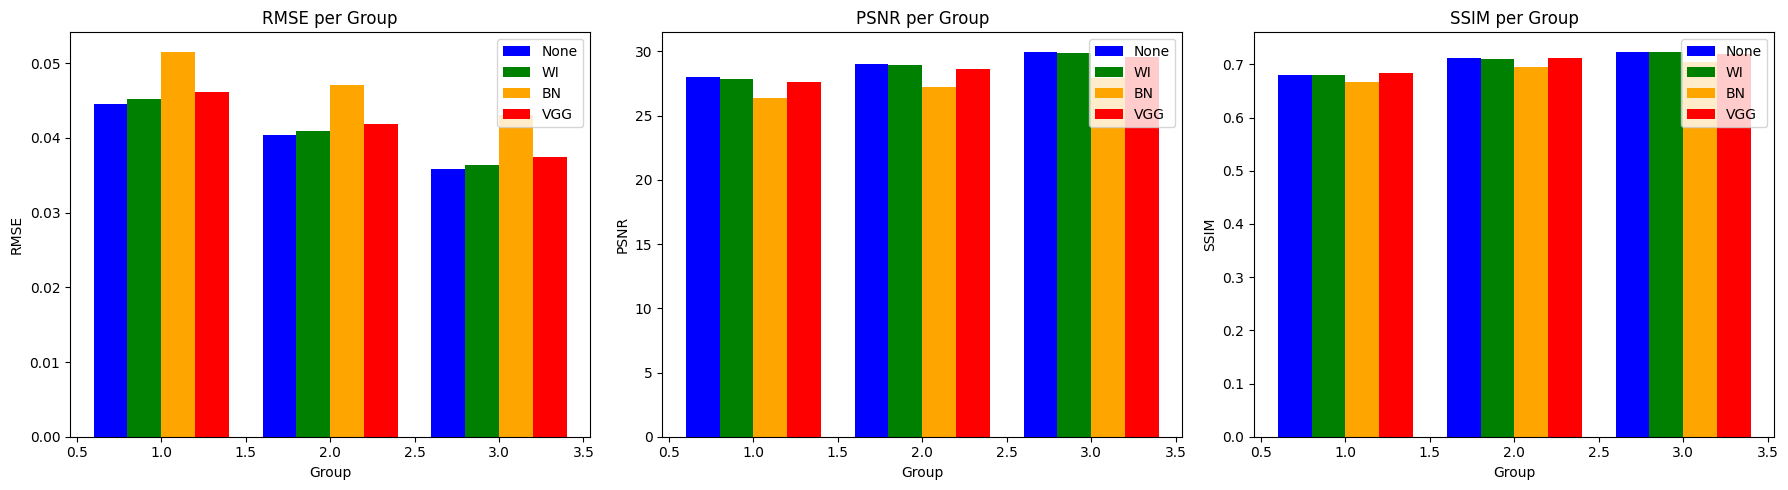

In [76]:
# 그룹화 (각각의 그룹 평균 계산)
None_rmse_groups = [np.mean(None_rmse_list[0:2]), np.mean(None_rmse_list[2:4]), np.mean(None_rmse_list[4:6])]
None_psnr_groups = [np.mean(None_psnr_list[0:2]), np.mean(None_psnr_list[2:4]), np.mean(None_psnr_list[4:6])]
None_ssim_groups = [np.mean(None_ssim_list[0:2]), np.mean(None_ssim_list[2:4]), np.mean(None_ssim_list[4:6])]

WI_rmse_groups = [np.mean(WI_rmse_list[0:2]), np.mean(WI_rmse_list[2:4]), np.mean(WI_rmse_list[4:6])]
WI_psnr_groups = [np.mean(WI_psnr_list[0:2]), np.mean(WI_psnr_list[2:4]), np.mean(WI_psnr_list[4:6])]
WI_ssim_groups = [np.mean(WI_ssim_list[0:2]), np.mean(WI_ssim_list[2:4]), np.mean(WI_ssim_list[4:6])]

BN_rmse_groups = [np.mean(BN_rmse_list[0:2]), np.mean(BN_rmse_list[2:4]), np.mean(BN_rmse_list[4:6])]
BN_psnr_groups = [np.mean(BN_psnr_list[0:2]), np.mean(BN_psnr_list[2:4]), np.mean(BN_psnr_list[4:6])]
BN_ssim_groups = [np.mean(BN_ssim_list[0:2]), np.mean(BN_ssim_list[2:4]), np.mean(BN_ssim_list[4:6])]

VGG_rmse_groups = [np.mean(VGG_rmse_list[0:2]), np.mean(VGG_rmse_list[2:4]), np.mean(VGG_rmse_list[4:6])]
VGG_psnr_groups = [np.mean(VGG_psnr_list[0:2]), np.mean(VGG_psnr_list[2:4]), np.mean(VGG_psnr_list[4:6])]
VGG_ssim_groups = [np.mean(VGG_ssim_list[0:2]), np.mean(VGG_ssim_list[2:4]), np.mean(VGG_ssim_list[4:6])]

# 그룹 인덱스
groups = np.array([1, 2, 3])
bar_width = 0.2
offset = bar_width

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
axs[0].bar(groups - 1.5 * offset, None_rmse_groups, bar_width, label='None', color='b')
axs[0].bar(groups - 0.5 * offset, WI_rmse_groups, bar_width, label='WI', color='g')
axs[0].bar(groups + 0.5 * offset, BN_rmse_groups, bar_width, label='BN', color='orange')
axs[0].bar(groups + 1.5 * offset, VGG_rmse_groups, bar_width, label='VGG', color='r')
axs[0].set_title('RMSE per Group')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('RMSE')
axs[0].legend()

# PSNR
axs[1].bar(groups - 1.5 * offset, None_psnr_groups, bar_width, label='None', color='b')
axs[1].bar(groups - 0.5 * offset, WI_psnr_groups, bar_width, label='WI', color='g')
axs[1].bar(groups + 0.5 * offset, BN_psnr_groups, bar_width, label='BN', color='orange')
axs[1].bar(groups + 1.5 * offset, VGG_psnr_groups, bar_width, label='VGG', color='r')
axs[1].set_title('PSNR per Group')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('PSNR')
axs[1].legend()

# SSIM
axs[2].bar(groups - 1.5 * offset, None_ssim_groups, bar_width, label='None', color='b')
axs[2].bar(groups - 0.5 * offset, WI_ssim_groups, bar_width, label='WI', color='g')
axs[2].bar(groups + 0.5 * offset, BN_ssim_groups, bar_width, label='BN', color='orange')
axs[2].bar(groups + 1.5 * offset, VGG_ssim_groups, bar_width, label='VGG', color='r')
axs[2].set_title('SSIM per Group')
axs[2].set_xlabel('Group')
axs[2].set_ylabel('SSIM')
axs[2].legend()

plt.tight_layout()
plt.show()

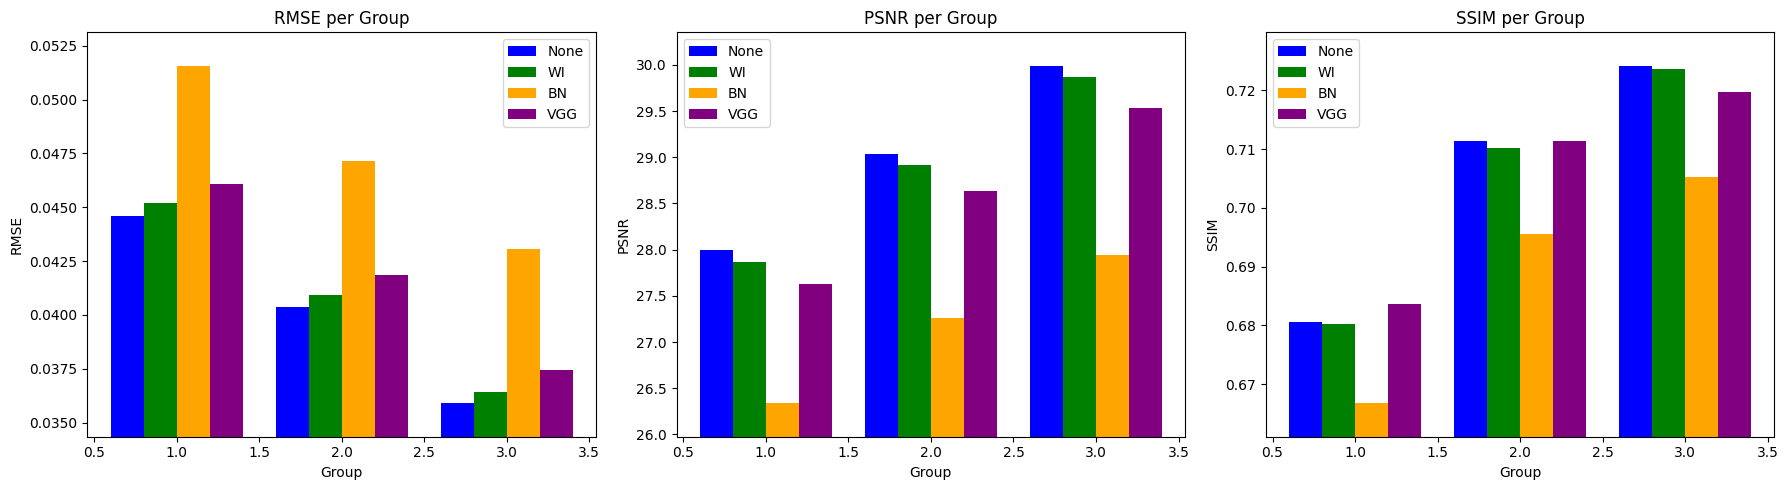

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# 예제 데이터
groups = np.array([1, 2, 3])
bar_width = 0.2  # 막대 너비
offset = bar_width

# 데이터 그룹
None_rmse_groups = [np.mean(None_rmse_list[0:2]), np.mean(None_rmse_list[2:4]), np.mean(None_rmse_list[4:6])]
WI_rmse_groups = [np.mean(WI_rmse_list[0:2]), np.mean(WI_rmse_list[2:4]), np.mean(WI_rmse_list[4:6])]
BN_rmse_groups = [np.mean(BN_rmse_list[0:2]), np.mean(BN_rmse_list[2:4]), np.mean(BN_rmse_list[4:6])]
VGG_rmse_groups = [np.mean(VGG_rmse_list[0:2]), np.mean(VGG_rmse_list[2:4]), np.mean(VGG_rmse_list[4:6])]

None_psnr_groups = [np.mean(None_psnr_list[0:2]), np.mean(None_psnr_list[2:4]), np.mean(None_psnr_list[4:6])]
WI_psnr_groups = [np.mean(WI_psnr_list[0:2]), np.mean(WI_psnr_list[2:4]), np.mean(WI_psnr_list[4:6])]
BN_psnr_groups = [np.mean(BN_psnr_list[0:2]), np.mean(BN_psnr_list[2:4]), np.mean(BN_psnr_list[4:6])]
VGG_psnr_groups = [np.mean(VGG_psnr_list[0:2]), np.mean(VGG_psnr_list[2:4]), np.mean(VGG_psnr_list[4:6])]

None_ssim_groups = [np.mean(None_ssim_list[0:2]), np.mean(None_ssim_list[2:4]), np.mean(None_ssim_list[4:6])]
WI_ssim_groups = [np.mean(WI_ssim_list[0:2]), np.mean(WI_ssim_list[2:4]), np.mean(WI_ssim_list[4:6])]
BN_ssim_groups = [np.mean(BN_ssim_list[0:2]), np.mean(BN_ssim_list[2:4]), np.mean(BN_ssim_list[4:6])]
VGG_ssim_groups = [np.mean(VGG_ssim_list[0:2]), np.mean(VGG_ssim_list[2:4]), np.mean(VGG_ssim_list[4:6])]

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# RMSE 그래프
rmse_values = np.concatenate([None_rmse_groups, WI_rmse_groups, BN_rmse_groups, VGG_rmse_groups])
y_min_rmse, y_max_rmse = rmse_values.min(), rmse_values.max()
y_margin_rmse = (y_max_rmse - y_min_rmse) * 0.1
y_min_rmse -= y_margin_rmse
y_max_rmse += y_margin_rmse

axs[0].bar(groups - offset * 1.5, None_rmse_groups, bar_width, label='None', color='b')
axs[0].bar(groups - offset * 0.5, WI_rmse_groups, bar_width, label='WI', color='g')
axs[0].bar(groups + offset * 0.5, BN_rmse_groups, bar_width, label='BN', color='orange')
axs[0].bar(groups + offset * 1.5, VGG_rmse_groups, bar_width, label='VGG', color='purple')
axs[0].set_ylim(y_min_rmse, y_max_rmse)
axs[0].set_title('RMSE per Group')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('RMSE')
axs[0].legend()

# PSNR 그래프
psnr_values = np.concatenate([None_psnr_groups, WI_psnr_groups, BN_psnr_groups, VGG_psnr_groups])
y_min_psnr, y_max_psnr = psnr_values.min(), psnr_values.max()
y_margin_psnr = (y_max_psnr - y_min_psnr) * 0.1
y_min_psnr -= y_margin_psnr
y_max_psnr += y_margin_psnr

axs[1].bar(groups - offset * 1.5, None_psnr_groups, bar_width, label='None', color='b')
axs[1].bar(groups - offset * 0.5, WI_psnr_groups, bar_width, label='WI', color='g')
axs[1].bar(groups + offset * 0.5, BN_psnr_groups, bar_width, label='BN', color='orange')
axs[1].bar(groups + offset * 1.5, VGG_psnr_groups, bar_width, label='VGG', color='purple')
axs[1].set_ylim(y_min_psnr, y_max_psnr)
axs[1].set_title('PSNR per Group')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('PSNR')
axs[1].legend()

# SSIM 그래프
ssim_values = np.concatenate([None_ssim_groups, WI_ssim_groups, BN_ssim_groups, VGG_ssim_groups])
y_min_ssim, y_max_ssim = ssim_values.min(), ssim_values.max()
y_margin_ssim = (y_max_ssim - y_min_ssim) * 0.1
y_min_ssim -= y_margin_ssim
y_max_ssim += y_margin_ssim

axs[2].bar(groups - offset * 1.5, None_ssim_groups, bar_width, label='None', color='b')
axs[2].bar(groups - offset * 0.5, WI_ssim_groups, bar_width, label='WI', color='g')
axs[2].bar(groups + offset * 0.5, BN_ssim_groups, bar_width, label='BN', color='orange')
axs[2].bar(groups + offset * 1.5, VGG_ssim_groups, bar_width, label='VGG', color='purple')
axs[2].set_ylim(y_min_ssim, y_max_ssim)
axs[2].set_title('SSIM per Group')
axs[2].set_xlabel('Group')
axs[2].set_ylabel('SSIM')
axs[2].legend()

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

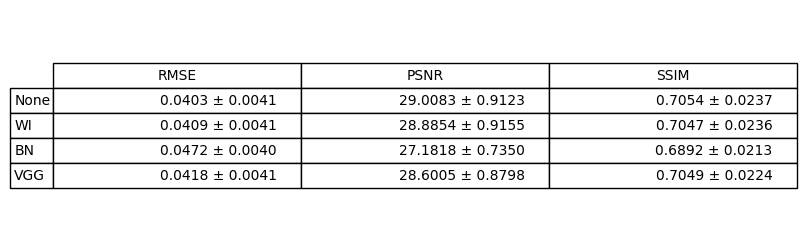

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# None 모델 결과
None_rmse_mean, None_rmse_sd = np.mean(None_rmse_list), np.std(None_rmse_list)
None_psnr_mean, None_psnr_sd = np.mean(None_psnr_list), np.std(None_psnr_list)
None_ssim_mean, None_ssim_sd = np.mean(None_ssim_list), np.std(None_ssim_list)

# WI 모델 결과
WI_rmse_mean, WI_rmse_sd = np.mean(WI_rmse_list), np.std(WI_rmse_list)
WI_psnr_mean, WI_psnr_sd = np.mean(WI_psnr_list), np.std(WI_psnr_list)
WI_ssim_mean, WI_ssim_sd = np.mean(WI_ssim_list), np.std(WI_ssim_list)

# BN 모델 결과
BN_rmse_mean, BN_rmse_sd = np.mean(BN_rmse_list), np.std(BN_rmse_list)
BN_psnr_mean, BN_psnr_sd = np.mean(BN_psnr_list), np.std(BN_psnr_list)
BN_ssim_mean, BN_ssim_sd = np.mean(BN_ssim_list), np.std(BN_ssim_list)

# VGG 모델 결과
VGG_rmse_mean, VGG_rmse_sd = np.mean(VGG_rmse_list), np.std(VGG_rmse_list)
VGG_psnr_mean, VGG_psnr_sd = np.mean(VGG_psnr_list), np.std(VGG_psnr_list)
VGG_ssim_mean, VGG_ssim_sd = np.mean(VGG_ssim_list), np.std(VGG_ssim_list)

# 결과를 mean ± sd 형식으로 표현
None_results = [
    f"{None_rmse_mean:.4f} ± {None_rmse_sd:.4f}",
    f"{None_psnr_mean:.4f} ± {None_psnr_sd:.4f}",
    f"{None_ssim_mean:.4f} ± {None_ssim_sd:.4f}"
]

WI_results = [
    f"{WI_rmse_mean:.4f} ± {WI_rmse_sd:.4f}",
    f"{WI_psnr_mean:.4f} ± {WI_psnr_sd:.4f}",
    f"{WI_ssim_mean:.4f} ± {WI_ssim_sd:.4f}"
]

BN_results = [
    f"{BN_rmse_mean:.4f} ± {BN_rmse_sd:.4f}",
    f"{BN_psnr_mean:.4f} ± {BN_psnr_sd:.4f}",
    f"{BN_ssim_mean:.4f} ± {BN_ssim_sd:.4f}"
]

VGG_results = [
    f"{VGG_rmse_mean:.4f} ± {VGG_rmse_sd:.4f}",
    f"{VGG_psnr_mean:.4f} ± {VGG_psnr_sd:.4f}",
    f"{VGG_ssim_mean:.4f} ± {VGG_ssim_sd:.4f}"
]

# 테이블 데이터
rows = ["None", "WI", "BN", "VGG"]
columns = ["RMSE", "PSNR", "SSIM"]
table_data = [None_results, WI_results, BN_results, VGG_results]

# 테이블 생성
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')  # 축 숨기기
ax.axis('tight')  # 테이블 맞춤 조정
table = ax.table(cellText=table_data, rowLabels=rows, colLabels=columns, loc='center')

# 스타일 설정
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)  # 테이블 크기 조정

plt.show()